<a href="https://colab.research.google.com/github/danielAdama/crop-mapping-classification/blob/main/Crop_mapping_using_fused_optical_radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal:** Is to develop a machine learning approach to make predictions on different crop cultures (e.g Corn, Pea, etc.) which is a multi-class classification task.

In [63]:
import pandas as pd
import os
import numpy as np
import pathlib
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score, accuracy_score, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline


pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (22, 10)

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

**Download the Zip file from the url and store locally**

In [2]:
CM_ZIP_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00525/data.zip"

BASE_DIR = pathlib.Path().resolve()
DATASET_DIR = BASE_DIR / "datasets"
DATASET_DIR.mkdir(exist_ok=True)

ZIPS_DIR = DATASET_DIR / "zips"
ZIPS_DIR.mkdir(exist_ok=True)

CM_ZIPS_PATH = ZIPS_DIR / "CM-dataset.zip"

# !curl $CM_ZIP_URL -o $CM_ZIPS_PATH

**Unzip the file**

In [3]:
UNZIPS_DIR = DATASET_DIR / "unzips"
UNZIPS_DIR.mkdir(exist_ok=True)
CM_DIR = UNZIPS_DIR / "CM-dataset"
UNZIPS_DIR.mkdir(exist_ok=True)

!unzip -o $CM_ZIPS_PATH -d $CM_DIR

Archive:  /content/datasets/zips/CM-dataset.zip
  inflating: /content/datasets/unzips/CM-dataset/WinnipegDataset.txt  


# 2. Exploratory Data Analysis and Pre-processing

In [4]:
raw_data = pd.read_csv(os.path.join(CM_DIR, "WinnipegDataset.txt"))
print(raw_data.shape)
print()
print(raw_data.info())
raw_data.head()

(325834, 175)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325834 entries, 0 to 325833
Columns: 175 entries, label to f174
dtypes: float64(169), int64(6)
memory usage: 435.0 MB
None


,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,0.04239,3.3253,3.3677,0.35631,0.058490,0.58520,0.24150,0.51934,0.23916,-0.62424,-0.81493,-0.70844,-0.65641,-0.19568,-0.63160,0.091945,0.026703,0.005017,0.62019,0.68370,44.369,0.42402,0.19617,0.25967,0.12013,0.054561,0.16226,-11.923,-12.823,-21.407,0.17610,0.16811,0.002613,0.066037,0.025145,0.028249,0.056669,0.037053,0.005979,0.024823,-12.564,-23.436,-13.858,-18.209,-11.5560,-17.934,1.2944,-10.873,-9.5783,-0.274930,6.6524,6.3775,0.54823,0.044843,0.40693,0.14944,0.69136,0.15920,-1.8727,-0.78500,-1.9895,-2.9965,-1.7738,-1.7326,0.071334,0.025359,0.004391,0.66368,0.70484,42.797,0.46779,0.19589,0.23705,0.099269,0.061549,0.17374,-11.5560,-15.740,-23.436,0.18156,0.11893,0.003407,0.057758,0.019568,0.017713,0.058723,0.019425,0.004282,0.016069,0.009,0.057,0.048,0.165,0.369,0.76978,7.6875,1.18750,0.50488,0.61842,0.52508,0.085714,0.73239,0.50279,0.38202,2.2364,-0.48649,17.28,0.54930,0.128250,7.38,3.4375,22.667,8.22220,0.27512,13.44400,3.00000,2.1972,0.11111,0.452700,7.7778,17.28400,0.27566,24.55600,3.66670,2.0432,0.13580,0.650770,6711,6143,4570,5064,8212,0.28493,1.7969,1.3442,-0.61941,0.54346,0.42738,0.14683,0.144130,0.58593,0.23712,1.6216,0.23712,294110.0,0.051277,2199.4,92560.0,1.1081,48.444,3.13580,0.57778,2.44440,1.11110,1.8310,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,0.22842,3.0360,3.2644,0.34295,0.060525,0.59652,0.25249,0.50796,0.23955,-0.57229,-0.74854,-0.64839,-0.62810,-0.18825,-0.55448,0.115710,0.031183,0.006051,0.60356,0.67496,44.992,0.40738,0.19618,0.26758,0.12886,0.052298,0.15826,-11.096,-11.805,-20.335,0.18909,0.18203,0.006412,0.078576,0.027181,0.034402,0.066831,0.043155,0.005979,0.027797,-11.559,-22.730,-12.844,-17.334,-10.5000,-17.095,1.2853,-11.172,-9.8863,-0.239200,6.8340,6.5948,0.54939,0.041949,0.40866,0.14534,0.70110,0.15357,-1.9547,-0.75344,-1.9783,-2.9398,-1.8280,-1.7547,0.090777,0.031174,0.005176,0.65128,0.71519,42.706,0.46579,0.18549,0.24940,0.099319,0.057024,0.16287,-10.5000,-14.859,-22.730,0.20112,0.12981,0.002202,0.071813,0.023410,0.019954,0.072635,0.023165,0.004282,0.018801,0.001,0.044,0.037,0.103,0.290,0.77370,7.8378,1.18920,0.42041,0.59780,0.45889,0.086420,0.73653,0.42498,0.47583,2.8155,-0.40136,16.24,0.47143,0.099454,4.24,2.7838,18.556,0.46914,0.60000,1.33330,0.88889,1.5230,0.23457,-0.132450,3.8889,0.32099,0.72222,0.55556,0.55556,1.2730,0.30864,0.104830,6274,5084,3297,3777,8214,0.42716,2.4914,1.5420,-0.64500,0.92501,0.64071,0.21322,0.235370,0.75089,0.37003,2.1747,0.37003,412400.0,0.067854,2338.4,100280.0,1.1456,49.778,0.39506,0.46667,1.33330,1.11110,1.2149,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,1,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,0.44978,2.7687,3.2185,0.34489,0.061731,0.59338,0.26362,0.49870,0.23768,-0.53347,-0.70253,-0.58846,-0.61836,-0.17804,-0.48642,0.127130,0.032382,0.006162,0.58683,0.68024,45.466,0.39919,0.18764,0.28105,0.13211,0.048473,0.14878,-10.829,-11.377,-19.902,0.19562,0.19066,0.010325,0.027212,0.086472,0.039597,0.072656,0.047041,0.005979,0.029540,-11.040,-22.566,-12.458,

# 3. Target Exploration (label)

**Labels based on index**

1. Corn
2. Pea
3. Canola
4. Soy
5. Oat
6. Wheat
7. Broadleaf

In [5]:
raw_data.label = raw_data.label.astype('int')
raw_data.label.value_counts().sort_index()

1    39162
2     3598
3    75673
4    74067
5    47117
6    85074
7     1143
Name: label, dtype: int64

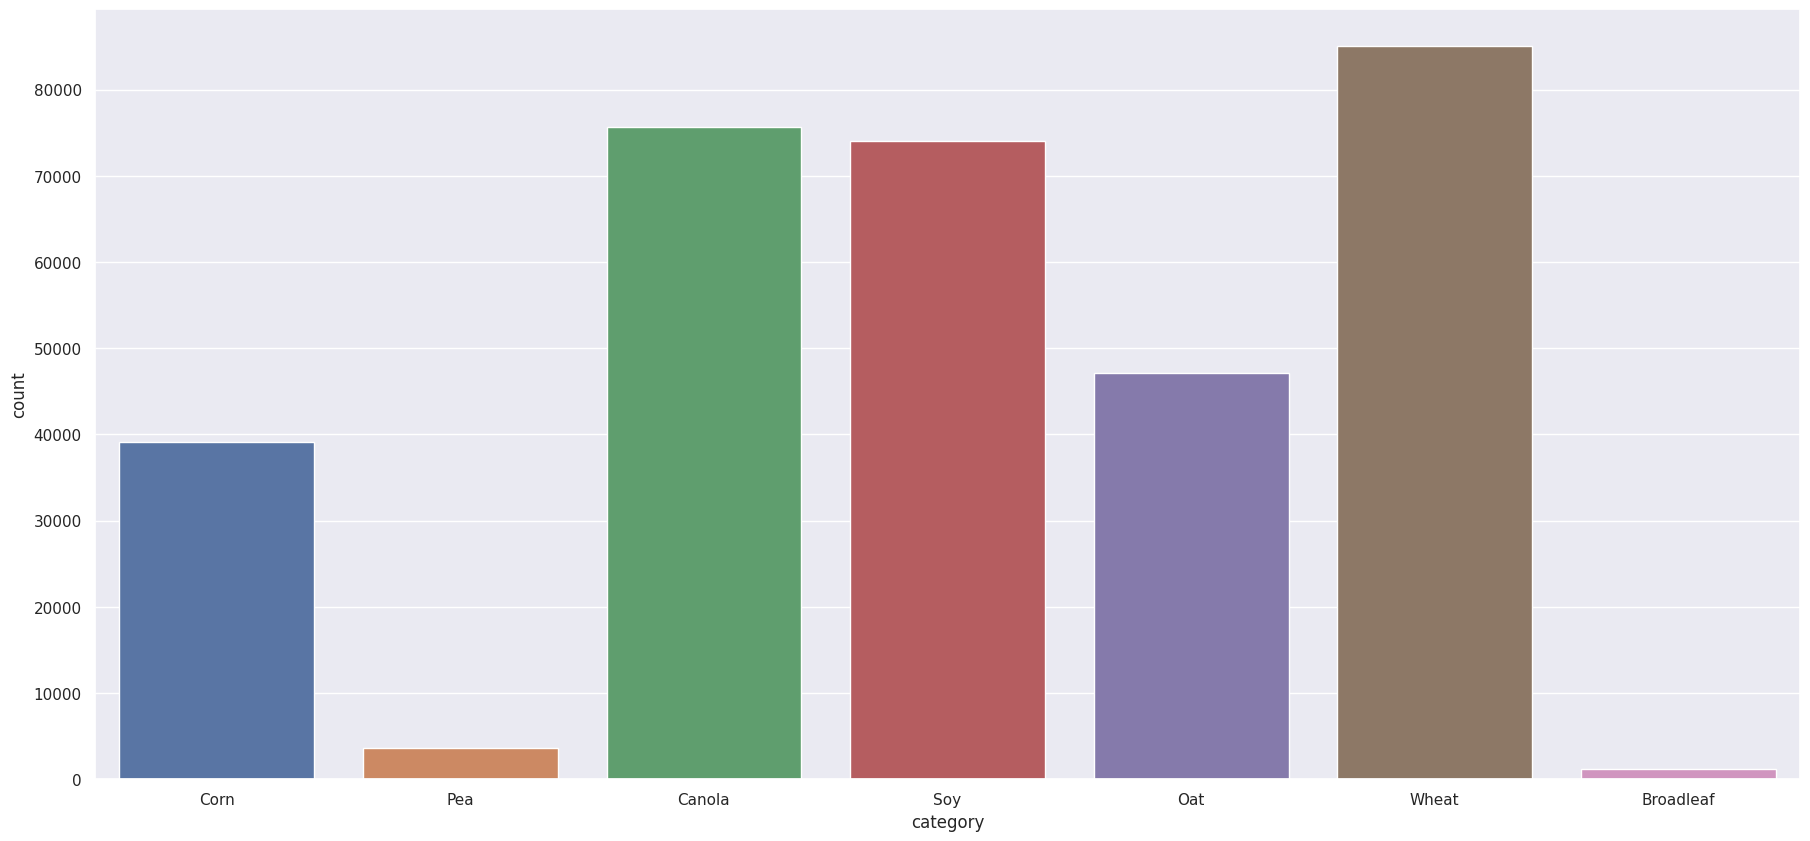

In [6]:
label_names = {1:'Corn', 2:'Pea', 3:'Canola', 4:'Soy', 5:'Oat', 6:'Wheat', 7:'Broadleaf'}
raw_data['category'] = raw_data['label'].map(label_names)
sns.countplot(x='category', data=raw_data)
plt.show()
raw_data.drop(['category'], axis=1, inplace=True)

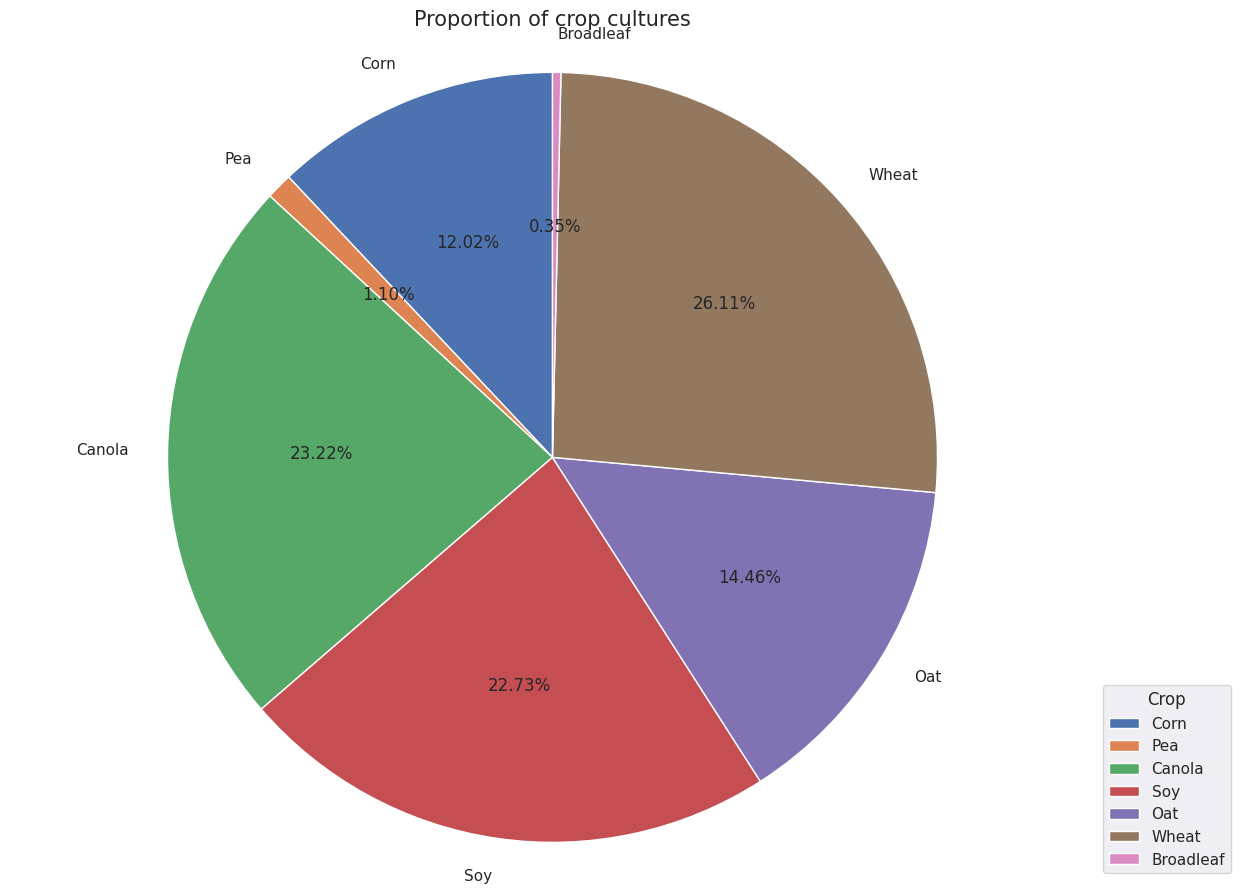

In [7]:
size = raw_data.label.value_counts().sort_index()
labels = 'Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'
fig, ax = plt.subplots(figsize = (14, 11))
ax.pie(size, explode = None, labels=labels, autopct='%2.2f%%', startangle=90)
ax.axis('equal')
plt.title('Proportion of crop cultures', size=15)
ax.legend(labels, bbox_to_anchor = (1, 0), loc = 'lower left', title = 'Crop')
plt.show()

Given, wheat makes up 26.11% of all crops, followed by canola (23.22%) and soy (22.73%). According to the baseline model, wheat will make up 26.11% of all crops. 

The business is more interested in identifying these crops than it is in accurately predicting the crops that are Wheat, Canola, and Soy, thus we need to make sure that the chosen model does not predict the others with lesser accuracy, such as Breadleaf 0.35%, Pea 1.10%.

# 4. Check for Outliers

In [8]:
raw_data.describe()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
count,325834.000000,325834.000000,325834.000000,325834.000000,325834.00000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,3.258340e+05,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,3.258340e+05,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000
mean,4.062421,-15.143602,-24.026035,-15.400034,-18.59383,-14.493472,-18.427329,0.256432,-8.882434,-8.626002,-0.166500,4.100357,3.933857,0.480376,0.064088,0.455535,0.217800,0.555515,0.226686,-1.517263,-1.608698,-1.181434,-1.592702,-0.308595,-1.486840,0.057962,0.025120,0.005054,0.715467,0.702775,41.669169,0.500494,0.214973,0.202282,0.082251,0.083237,0.209597,-14.493472,-16.190682,-24.026035,0.142869,0.127552,6.215130e-03,0.034536,0.029085,0.024727,0.036791,0.029027,0.006083,0.021235,-17.032833,-26.717638,-18.747312,-21.423108,-16.771375,-21.235700,1.714480,-9.684806,-7.970327,-0.187407,4.651733,4.464326,0.556719,0.062170,0.381110,0.202417,0.586375,0.211207,-2.084016,-1.258692,-1.975972,-2.266397,-1.883872,-1.478220,0.033008,0.014529,0.003190,0.719414,0.660229,41.743319,

There is no much difference between the max and the mean of each features. Therefore, we can say there are no outliers present. We will go deeper into the distributions.

## 4.1 Outlier Detection and Treatment

### IQR (Inter Quantile Range) for Outlier Detection

In [9]:
def detect_outliers(df, remove_outlier = True):
    
    """
    Function to detect the presence of Outliers in a column
    when remove_outler = False or to remove 
    Outliers when remove_outler = True
    
    Args:
        df (Dataframe) : dataframe of the data
        col (string) : column name of the data
    
    Returns:
        float : detected outliers
    """
    
    if remove_outlier:
        # 1st quantile is 0.1%
        Q1 = df.quantile(0.001)
        # 3rd quantile is 99.9%
        Q3 = df.quantile(0.999)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR

        return df.loc[~((df < lower_limit) | (df > upper_limit)).any(axis=1)]
    
    else:
        print('Shape before outlier removal -> ',df.shape)
        Q1 = df.quantile(0.001)
        Q3 = df.quantile(0.999)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR
        
        return df.loc[((df < lower_limit) | (df > upper_limit)).any(axis=1)]

In [10]:
detect_outliers(raw_data, remove_outlier = False)

Shape before outlier removal ->  (325834, 175)


,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.55900,-21.4070,-11.40400,-15.24800,-11.92300,-15.29100,-2.15480,-7.8474,-10.0020,0.042390,3.32530,3.36770,0.35631,0.058490,0.58520,0.24150,0.51934,0.23916,-0.62424,-0.81493,-0.70844,-0.65641,-0.195680,-0.63160,0.091945,0.026703,0.005017,0.62019,0.68370,44.369,0.42402,0.196170,0.25967,0.120130,0.054561,0.162260,-11.92300,-12.82300,-21.4070,0.17610,0.16811,0.002613,0.066037,0.025145,0.028249,0.056669,0.037053,0.005979,0.024823,-12.5640,-23.436,-13.8580,-18.2090,-11.55600,-17.9340,1.294400,-10.8730,-9.5783,-0.27493,6.6524,6.3775,0.54823,0.044843,0.40693,0.14944,0.69136,0.15920,-1.87270,-0.78500,-1.98950,-2.99650,-1.77380,-1.73260,0.071334,0.025359,0.004391,0.66368,0.70484,42.797,0.46779,0.195890,0.23705,0.099269,0.061549,0.173740,-11.55600,-15.74000,-23.436,0.18156,0.11893,0.003407,0.057758,0.019568,0.017713,0.058723,0.019425,0.004282,0.016069,0.009,0.057,0.048,0.165,0.369,0.76978,7.6875,1.18750,0.50488,0.61842,0.52508,0.085714,0.73239,0.50279,0.38202,2.2364,-0.48649,17.28,0.54930,0.128250,7.38,3.4375,22.667,8.2222,0.27512,13.4440,3.0000,2.1972,0.11111,0.452700,7.7778,17.28400,0.27566,24.55600,3.66670,2.04320,0.13580,0.650770,6711,6143,4570,5064,8212,0.284930,1.7969,1.3442,-0.61941,0.54346,0.42738,0.14683,0.144130,0.58593,0.23712,1.6216,0.23712,294110.0,0.051277,2199.40,92560.0,1.10810,48.444,3.13580,0.57778,2.44440,1.11110,1.8310,0.18519,0.726020,5.3333,6.00000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
312,1,-15.89900,-22.5160,-12.33900,-16.32000,-13.39000,-16.87700,-3.56030,-6.6169,-10.1770,0.556740,2.93030,3.48710,0.28670,0.062479,0.65082,0.26020,0.51091,0.22889,-0.58056,-0.87370,-0.65135,-0.58037,-0.197190,-0.64533,0.067394,0.018456,0.003820,0.61390,0.65702,44.934,0.40334,0.210560,0.25368,0.132430,0.056685,0.170410,-13.39000,-14.17300,-22.5160,0.15022,0.14522,0.007463,0.049801,0.016636,0.023094,0.042293,0.027533,0.005979,0.017482,-14.1670,-23.846,-13.6570,-19.1680,-12.16300,-18.9850,-0.509960,-9.6788,-10.1890,-0.18364,7.0050,6.8213,0.44797,0.048236,0.50379,0.14163,0.71063,0.14774,-1.78130,-0.68171,-1.74150,-2.42040,-1.64870,-1.96010,0.061547,0.020024,0.003942,0.65399,0.67106,48.630,0.43886,0.215120,0.23220,0.113820,0.064043,0.184380,-12.16300,-16.85700,-23.846,0.17016,0.10946,0.002061,0.049882,0.015858,0.016585,0.050078,0.016117,0.004282,0.015674,0.002,0.045,0.037,0.120,0.285,0.77019,7.7027,1.21620,0.41555,0.59664,0.45255,0.097561,0.72727,0.41885,0.40741,2.3750,-0.45455,14.10,0.52866,0.103050,5.30,3.2432,19.667,4.8889,0.56937,8.7778,1.8889,1.5811,0.25926,-0.080582,6.7778,14.39500,0.56110,22.22200,2.88890,1.42710,0.28395,-0.258850,6426,5812,4052,4725,7921,0.323140,1.9548,1.4344,-0.60601,0.65038,0.48470,0.17843,0.153570,0.65626,0.25273,1.6764,0.25273,298510.0,0.076678,2779.50,110780.0,1.16610,49.000,1.33330,0.63333,2.33330,1.00000,1.3108,0.28395,-0.612370,4.2222,5.95060,0.55172,7.77780,1.77780,1.67700,0.20988,0.53940
2229,1,-15.11200,-22.0090,-12.68900,-16.81100,-13.26100,-16.39800,-2.42360,-6.8971,-9.3207,-0.413850,3.55050,3.13670,0.33880,0.069221,0.59198,0.22910,0.51889,0.25201,-0.72995,-0.90324,-0.68642,-0.72736,-0.229990,-0.77446,0.064965,0.021686,0.004307,0.66140,0.66863,44.486,0.44223,0.219170,0.22640,0.112200,0.066290,0.189390,-13.26100,-14.26400,-22.00

In [11]:
data = detect_outliers(raw_data)

In [12]:
data.shape

(325469, 175)

# 5. Check for Missing Values

In [13]:
data.isnull().sum()

label    0
f1       0
f2       0
f3       0
f4       0
        ..
f170     0
f171     0
f172     0
f173     0
f174     0
Length: 175, dtype: int64

# 6. Correlation

The correlation between each feature and the dependent variable, as well as the correlation among features (intercorrelation), provide elements to tackle potential undesired collinearity.

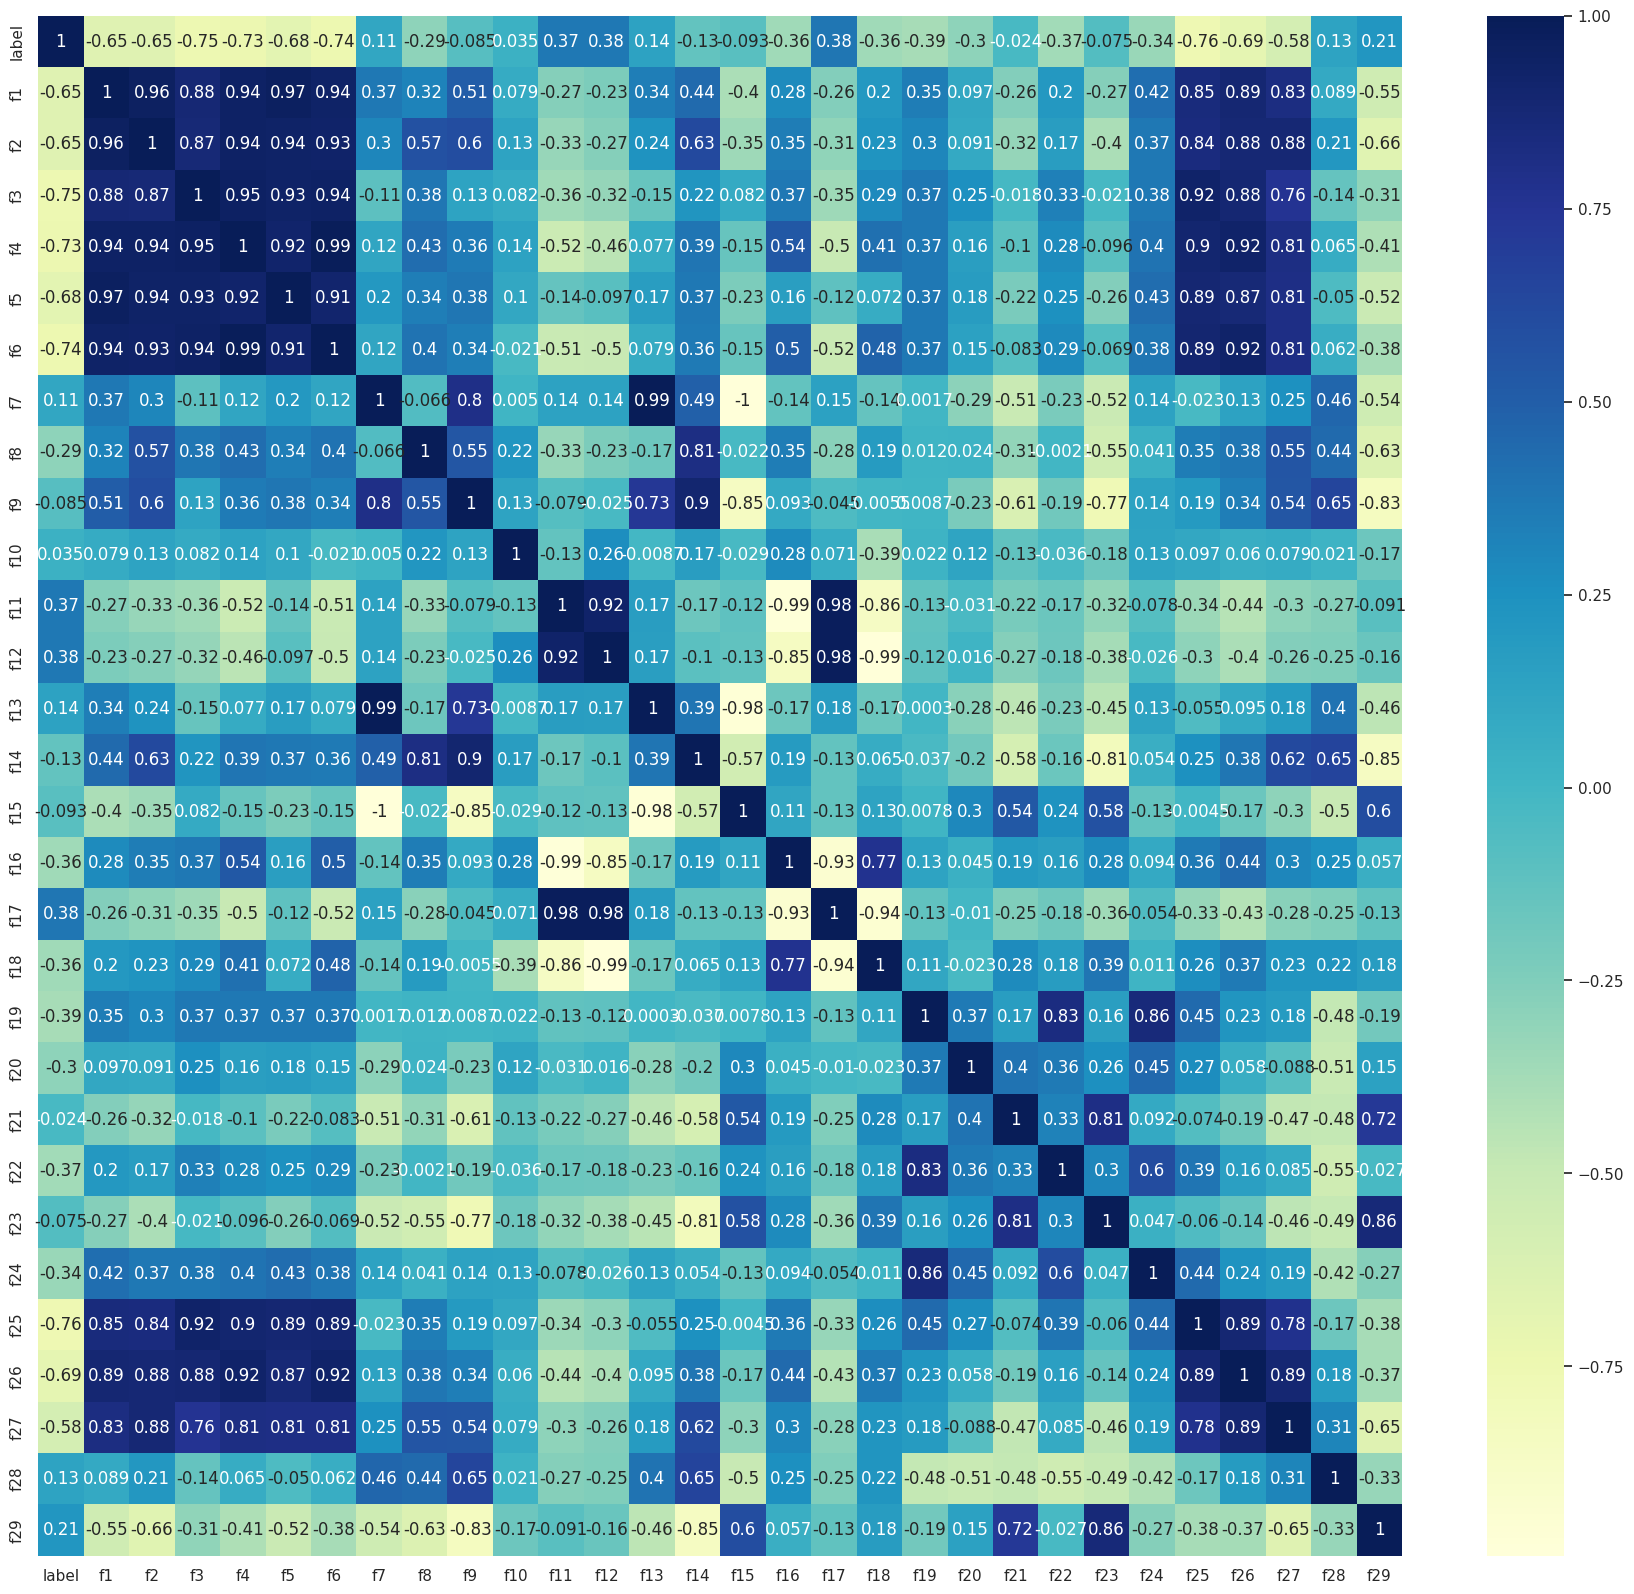

In [14]:
plt.figure(figsize=(22, 20))
corr_matrix = data.corr()
# Display the first 50 columns
sns.heatmap(corr_matrix.iloc[:30, :30], annot = True, cmap="YlGnBu")
plt.show()

In [15]:
corr_matrix.label.sort_values(ascending=False)

label    1.000000
f159     0.508915
f78      0.433738
f111     0.391795
f17      0.384036
           ...   
f50     -0.802042
f88     -0.808972
f51     -0.808972
f86     -0.809995
f54     -0.809995
Name: label, Length: 175, dtype: float64

In [16]:
print(max([x for x in corr_matrix.label if isinstance(x, (int, float)) and x != 1]))

0.5089148089395014


In [17]:
corr_matrix.label.min()

-0.8099949845258677

## 6.1 Feature Selection based on the correlation matrix

In [18]:
def correlated_feature_extraction(threshold: int = 0.01):
  
  """ Method that selects features based on the most correlated features with the label classes
  """
  corr_matrix_threshold = corr_matrix[abs(corr_matrix) > 0.01]

  # create a set of all feature labels
  feature_labels = set(corr_matrix.columns)

  # create an empty set to store the most correlated features
  most_correlated_features = set()

  # loop over all features
  for feature_label in feature_labels:
      # get the correlated values of the current feature with all other features
      correlated_features = set(corr_matrix_threshold[feature_label].dropna().index)
      # remove the current feature from the set of correlated features
      correlated_features.remove(feature_label)
      # check if the current feature has at least one highly correlated feature
      if len(correlated_features) > 0:
          # add the most highly correlated feature to the set of most correlated features
          most_correlated_feature = max(correlated_features, key=lambda x: abs(corr_matrix.loc[x, feature_label]))
          most_correlated_features.add(most_correlated_feature)


  print(most_correlated_features)
  selected_features = list(most_correlated_features)
  # selected_features.append('label')

  print('Total number of features before correlation: ',data.shape[1])
  print('Most correlated features: ', len(most_correlated_features))

  return selected_features, data[selected_features]

In [19]:
selected_feats, data_cleaned = correlated_feature_extraction()

{'f83', 'f48', 'f47', 'f44', 'f10', 'f24', 'f17', 'f173', 'f30', 'f92', 'f121', 'f133', 'f5', 'f29', 'f149', 'f125', 'f6', 'f11', 'f67', 'f162', 'f23', 'f88', 'f36', 'f34', 'f107', 'f35', 'f45', 'f16', 'f65', 'f62', 'f96', 'f124', 'f42', 'f131', 'f60', 'f122', 'f54', 'f85', 'f163', 'f14', 'f159', 'f59', 'f63', 'f84', 'f33', 'f144', 'f101', 'f169', 'f87', 'f139', 'f142', 'f19', 'f95', 'f120', 'f126', 'f167', 'f43', 'f28', 'f141', 'f156', 'f37', 'f41', 'f140', 'f111', 'f91', 'f56', 'f104', 'f113', 'f172', 'f31', 'f82', 'f105', 'f146', 'f108', 'f7', 'f51', 'f64', 'f158', 'f134', 'f12', 'f127', 'f38', 'f147', 'f114', 'f70', 'f135', 'f94', 'f109', 'f46', 'f76', 'f53', 'f86', 'f153', 'f72', 'f81', 'f68', 'f15', 'f32', 'f100', 'f155', 'f129', 'f80', 'f148', 'f93', 'f138', 'f49', 'f165', 'f157', 'f2', 'f102', 'f39', 'f171', 'f66', 'f132', 'f103', 'f161', 'f79', 'f117', 'f151', 'f78', 'f18', 'f164', 'f61'}
Total number of features before correlation:  175
Most correlated features:  123


In [20]:
data_cleaned.head()

,f83,f48,f47,f44,f10,f24,f17,f173,f30,f92,f121,f133,f5,f29,f149,f125,f6,f11,f67,f162,f23,f88,f36,f34,f107,f35,f45,f16,f65,f62,f96,f124,f42,f131,f60,f122,f54,f85,f163,f14,f159,f59,f63,f84,f33,f144,f101,f169,f87,f139,f142,f19,f95,f120,f126,f167,f43,f28,f141,f156,f37,f41,f140,f111,f91,f56,f104,f113,f172,f31,f82,f105,f146,f108,f7,f51,f64,f158,f134,f12,f127,f38,f147,f114,f70,f135,f94,f109,f46,f76,f53,f86,f153,f72,f81,f68,f15,f32,f100,f155,f129,f80,f148,f93,f138,f49,f165,f157,f2,f102,f39,f171,f66,f132,f103,f161,f79,f117,f151,f78,f18,f164,f61
1,0.099319,0.005979,0.043155,0.027181,0.22842,-0.55448,0.50796,0.50617,44.992,0.071813,18.556,0.55556,-11.096,0.67496,0.235370,0.88889,-14.361,3.0360,0.15357,1.33330,-0.18825,-22.730,0.15826,0.12886,0.42041,0.052298,0.034402,0.25249,0.14534,0.54939,0.023165,1.33330,0.006412,0.72222,6.8340,0.46914,-10.5000,0.16287,1.11110,0.060525,49.778,-0.239200,0.041949,0.057024,0.26758,1.5420,0.037,0.83333,-14.859,3297,0.42716,-0.57229,0.072635,2.7838,1.5230,2.1111,0.078576,0.60356,8214,2338.4,-11.096,0.18203,3777,0.73653,0.002202,1.2853,0.77370,0.47583,0.84869,0.40738,0.24940,7.8378,0.92501,0.59780,-2.4039,-22.730,0.40866,1.1456,1.2730,3.2644,0.23457,-11.805,0.64071,2.8155,-1.9783,0.30864,0.019954,0.45889,0.066831,0.005176,-17.334,-10.5000,0.37003,-1.8280,0.18549,-1.9547,0.59652,0.19618,0.044,0.067854,3.8889,0.46579,0.21322,0.023410,5084,0.027797,0.33333,100280.0,-20.335,0.103,-20.335,0.33333,0.70110,0.55556,0.290,0.46667,42.706,0.47143,0.37003,0.71519,0.23955,1.2149,6.5948
2,0.101030,0.005979,0.047041,0.086472,0.44978,-0.48642,0.49870,0.30864,45.466,0.083737,19.000,0.66667,-10.829,0.68024,0.260810,1.11110,-14.048,2.7687,0.14570,0.77778,-0.17804,-22.566,0.14878,0.13211,0.40217,0.048473,0.039597,0.26362,0.14467,0.55811,0.025911,2.44440,0.010325,0.66667,6.9065,0.66667,-9.9970,0.15439,0.77778,0.061731,49.444,-0.030712,0.039276,0.053338,0.28105,1.6601,0.046,0.68889,-14.509,3033,0.47801,-0.53347,0.084201,2.3261,1.6770,2.2222,0.027212,0.58683,8588,3321.3,-10.829,0.19066,3837,0.73256,0.000408,1.4183,0.73256,0.47160,1.27300,0.39919,0.26068,6.4783,1.03530,0.53213,-2.3566,-22.566,0.40261,1.2651,1.2730,3.2185,0.20988,-11.377,0.71699,2.7850,-2.1281,0.30864,0.021257,0.44787,0.072656,0.005443,-16.903,-9.9970,0.38237,-2.1057,0.17829,-2.3606,0.59338,0.18764,0.046,0.117030,3.8889,0.46000,0.24814,0.026262,5035,0.029540,0.25926,128320.0,-19.902,0.107,-19.902,0.66667,0.70963,0.66667,0.298,0.61111,42.195,0.39869,0.38237,0.72068,0.23768,1.3689,6.8757
3,0.105250,0.005979,0.048926,0.091109,0.66378,-0.43576,0.47717,0.38272,46.654,0.092551,17.333,1.11110,-11.056,0.67468,0.144830,1.33330,-14.014,2.2942,0.13593,0.77778,-0.17507,-22.520,0.14701,0.13738,0.32957,0.047480,0.042959,0.28135,0.13988,0.54798,0.027699,2.00000,0.014031,0.53333,7.1408,1.55560,-9.6992,0.14955,0.77778,0.067825,50.667,0.124570,0.037823,0.050939,0.28492,1.3640,0.074,0.83333,-14.532,4212,0.29228,-0.50405,0.093280,1.6216,1.5230,4.1111,0.025256,0.57769,7691,1748.1,-11.056,0.19425,4534,0.60000,0.000934,1.2156,0.58659,0.40594,1.14910,0.38976,0.26918,3.8378,0.65772,0.37198,-2.6611,-22.520,0.41419,1.0764,1.8892,2.9580,0.23457,-11.263,0.43840,2.3667,-2.2977,0.16049,0.021817,0.36713,0.075066,0.005533,-16.840,-9.6992,0.25824,-2.3477,0.17584,-2.6845,0.60457,0.18793,0.071,0.036817,6.2222,0.44972,0.15396,0.028162,5745,0.029684,0.16049,80640.0,-19.529,0.120,-19.529,0.33333,0.72419,2.00000,0.284,0.61111,42.803,0.23711,0.25824,0.71891,0.24148,1.8892,7.2654
4,0.104210,0.006601,0.050707,0.094832,0.83143,-0.45195,0.47476,0.20988,46.828,0.099970,16.667,0.88889,-10.932,0.66460,0.091779,0.77778,-13.939,2.1756,0.13526,1.66670,-0.17505,-22.387,0.15156,0.14108,0.32678,0.048950,0.046036,0.28768,0.13737,0.55209,0.029589,0.77778,0.016015,0.60000,7.2387,0.44444,-9.3839,0.14325,1.00000,0.069483,51.222,0.067196,0.036431,0.048530,0.27955,1.3268,0.068,0.68889,-14.269,4434,0.22927,-0.50314,0.100950,1.9265,1.2730,4.0000,0.023308,0.57937,7072,1365.4,-10.932,0.19809,4627,0.60000,0.001512,1.2767,0.59036,

In [65]:
# We assign the dependent feature to a variable y
y = data.label.values
# We assign the independent features to a variable x
x = data_cleaned.values


def roc_auc_graph(y_test, y_proba):

  # Get ROC metrics for each class
  fpr = {}
  tpr = {}
  thresh ={}
  for i in range(len(classes)):    
      fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_proba[:,i], pos_label=i)
      
  # Plot the ROC chart
  # plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=str(classes[0]) + ' vs Rest')
  plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Corn' + ' vs Rest')
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Pea' + ' vs Rest')
  plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Canola' + ' vs Rest')
  plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Soy' + ' vs Rest')
  plt.plot(fpr[4], tpr[4], linestyle='--',color='yellow', label='Oat' + ' vs Rest')
  plt.plot(fpr[5], tpr[5], linestyle='--',color='pink', label='Wheat' + ' vs Rest')
  plt.plot(fpr[6], tpr[6], linestyle='--',color='black', label='Broadleaf' + ' vs Rest')
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()

def confusion_matrix_plot(y_test, y_pred_test):
    
    """Function to visualize how well the model performed on the test set."""
    # cm = confusion_matrix(y_test, y_pred)
    cm = np.zeros((7,7))
    pred_correct = 0
    pred_incorrect = 0
    for i in range(len(y_test)):
        index_test = y_test[i] - 1
        index_pred = y_pred_test[i] - 1
        cm[index_test][index_pred] += 1
        if index_test == index_pred:
            pred_correct += 1
        else:
            pred_incorrect += 1
    
    cm_df = pd.DataFrame((cm.astype('int')),
                     index = ['Corn','Pea','Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'], 
                     columns = ['Corn','Pea','Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf']
                     )
    plt.figure(figsize=(10,6))
    sns.heatmap(cm_df, annot= cm, fmt='g', cmap='YlGnBu')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

    return cm_df
    
def evaluate(y_train, y_pred_train, y_test, y_pred_test):
  print("Accuracy:",accuracy_score(y_train, y_pred_train))
  print("Overall Accuracy:",accuracy_score(y_test, y_pred_test))
  print("Precision:",precision_score(y_train, y_pred_train, average='macro'))
  print("Overall Precision:",precision_score(y_test, y_pred_test, average='macro'))
  print("Recall:",recall_score(y_train, y_pred_train, average='macro'))
  print("Overall Recall:",recall_score(y_test, y_pred_test, average='macro'))
  print(classification_report(y_test, y_pred_test))

# Baseline Model
Baseline Model is trained with all the data. And then we will perform Feature Engineering to improve the model AUC and Accuracy

In [46]:
all_x = data.drop(['label'], axis=1)
all_y = data.label.values
X_train, X_test, y_train, y_test = train_test_split(all_x.values, all_y, random_state = 42, stratify = all_y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

baseModel = RandomForestClassifier()
baseModel.fit(X_train, y_train)
classes = baseModel.classes_

y_pred_train = baseModel.predict(X_train)
y_pred_test = baseModel.predict(X_test)
y_proba = baseModel.predict_proba(X_test)

evaluate(y_train, y_pred_train, y_test, y_pred_test)

For information only (a first sanity check), the first prediction in the 'y_pred' array matches the actual class for the corresponding test set observation hosted in the 'y_test' array. So far, so good..

Predicted class: [3 6 3 6 6 4 4 6 5 1]
Actual class: [3 6 3 6 6 4 4 6 5 1]


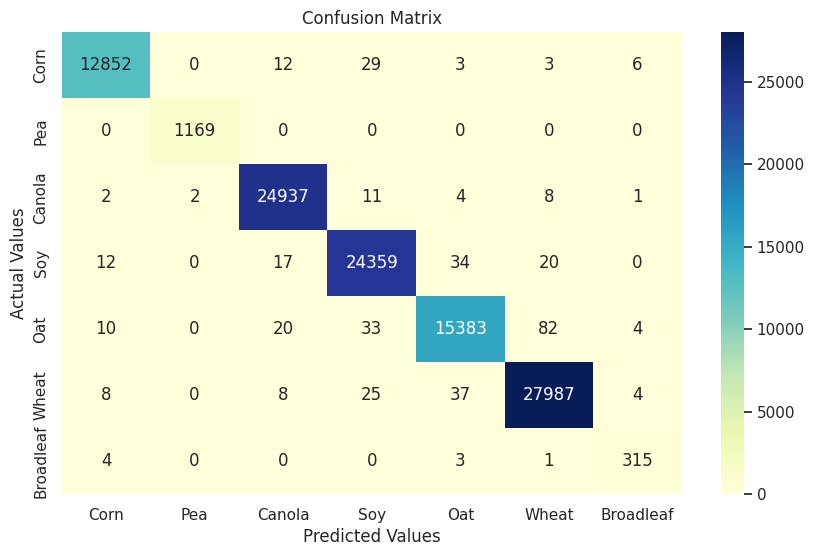

In [29]:
print(f'Predicted class: {y_pred_test[:10]}')
print(f'Actual class: {y_test[:10]}')
cm_matrix = confusion_matrix_plot(y_test, y_pred_test)

For the confusion matrix, the digits outside the diagonal should be as low as possible while the diagonal values should be as high as possible this give us an idea that our model is good or bad, in this case our model is good! but note that Pea and Broadleaf has lower values because it has less data points therefore, it won't make good predictions on either the Pea or Wheat.

The darker squares in the confusion matrix plot indicate high numbers of cases, and you can hopefully see a diagonal line of darker squares indicating cases where the predicted and actual label are the same.

In the case of a multiclass classification model, a single ROC curve showing true positive rate vs false positive rate is not possible. However, you can use the rates for each class in a **One vs Rest (OVR)** comparison to create a ROC chart for each class.

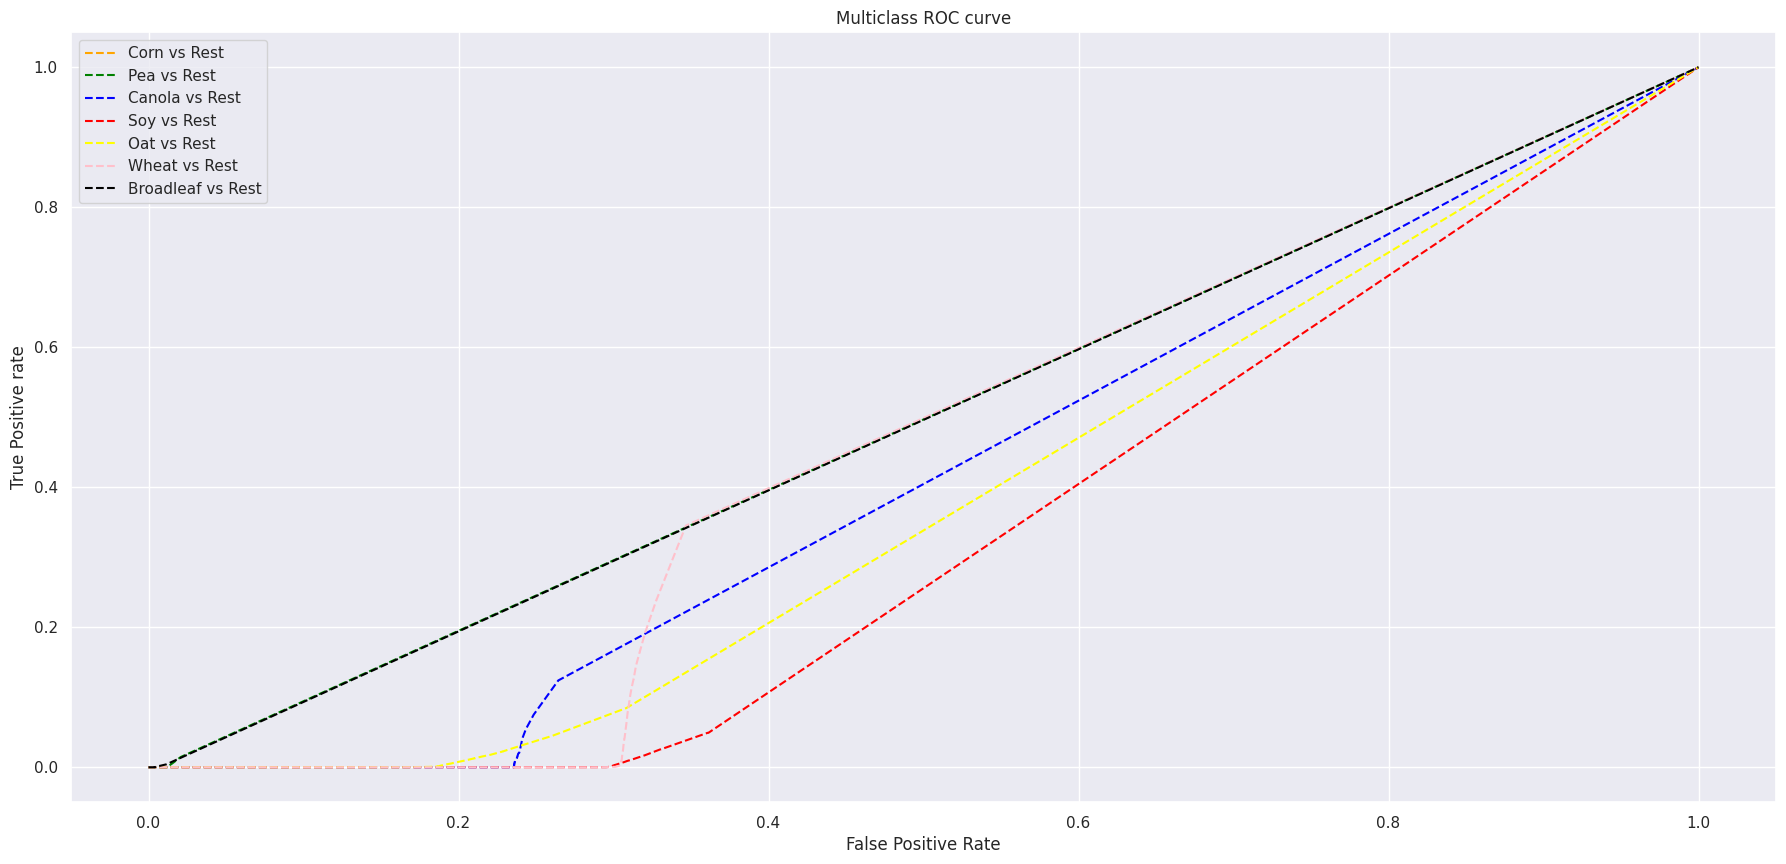

In [30]:
roc_auc_graph(y_test, y_proba)

In [36]:
to_delete = ['X_train', 'X_test', 'y_train', 'y_test', 'y_pred_train', 'y_pred_test', 'y_proba']
for _var in to_delete:
    if _var in locals() or _var in globals():
        exec(f'del {_var}')

# 7. Split and Scale the Data

Finally, label tensors (numpy arrays) are created for each separate exercise (traditional algorithms and neural network).

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, test_size=0.33)
y_train_ann = pd.get_dummies(y_train).values
y_test_ann = pd.get_dummies(y_test).values

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(218064, 123) (107405, 123) (218064,) (107405,)


## 7.1 Feature scaling

**Scaling is performed on the training feature set only and applied to both training and testing feature sets (with the 'fit_transform' and 'transform' methods, respectively).**

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 8. Model Building & Evaluation

Our main metric here would be Recall values, while AUC ROC Score would take care of how well predicted probabilites are able to differentiate between the 7 classes.

In [39]:
rand_f = RandomForestClassifier()
rand_f.fit(X_train, y_train)

y_proba = rand_f.predict_proba(X_test)
y_pred_test = rand_f.predict(X_test)
y_pred_train = rand_f.predict(X_train)

evaluate(y_train, y_pred_train, y_test, y_pred_test)

Accuracy: 0.9999266270452711
Overall Accuracy: 0.9959964619896653
Precision: 0.9992997551946755
Overall Precision: 0.9911668784544411
Recall: 0.9999383352018609
Overall Recall: 0.9930785808453287


**Notice :** That the feature selection based on the most correlated gives a slightly lower Accuracy and ROC scores than using all the features. Lets dive deeper with other Features selection techniques using the entire features.

## 6.2 Feature Selection based on model (Random Forest) selection

In [47]:
X_train, X_test, y_train, y_test = train_test_split(all_x.values, all_y, random_state = 42, stratify = all_y, test_size=0.33)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model_for_feature_selection = RandomForestClassifier()
model_for_feature_selection.fit(X_train, y_train)

RandomForestClassifier()

In [57]:
cols_todisplay = 30
importance_feat = model_for_feature_selection.feature_importances_
sorted_idx = np.argsort(importance_feat)[::-1]

print('These are the most importance Features\n')
for i in range(cols_todisplay):
    print(f"{i + 1,cols_todisplay} {all_x.columns[sorted_idx[i]]} ----> {importance_feat[sorted_idx[i]]:.12f}\n")

These are the most importance Features

(1, 30) f140 ----> 0.043548034864

(2, 30) f138 ----> 0.043354420670

(3, 30) f102 ----> 0.033575314004

(4, 30) f129 ----> 0.028415664030

(5, 30) f113 ----> 0.022949379429

(6, 30) f100 ----> 0.022093059211

(7, 30) f118 ----> 0.021586660509

(8, 30) f92 ----> 0.021014577871

(9, 30) f99 ----> 0.019475309995

(10, 30) f119 ----> 0.018829220823

(11, 30) f25 ----> 0.017715958795

(12, 30) f114 ----> 0.016722365124

(13, 30) f62 ----> 0.016525087833

(14, 30) f111 ----> 0.016349689779

(15, 30) f1 ----> 0.016185513258

(16, 30) f104 ----> 0.016123613990

(17, 30) f37 ----> 0.016051656287

(18, 30) f64 ----> 0.015876216959

(19, 30) f56 ----> 0.014098120719

(20, 30) f52 ----> 0.013956944867

(21, 30) f75 ----> 0.013867119616

(22, 30) f121 ----> 0.013684711040

(23, 30) f40 ----> 0.012182146375

(24, 30) f79 ----> 0.011515998532

(25, 30) f156 ----> 0.010816246997

(26, 30) f103 ----> 0.010765257751

(27, 30) f86 ----> 0.010466764650

(28, 30) f1

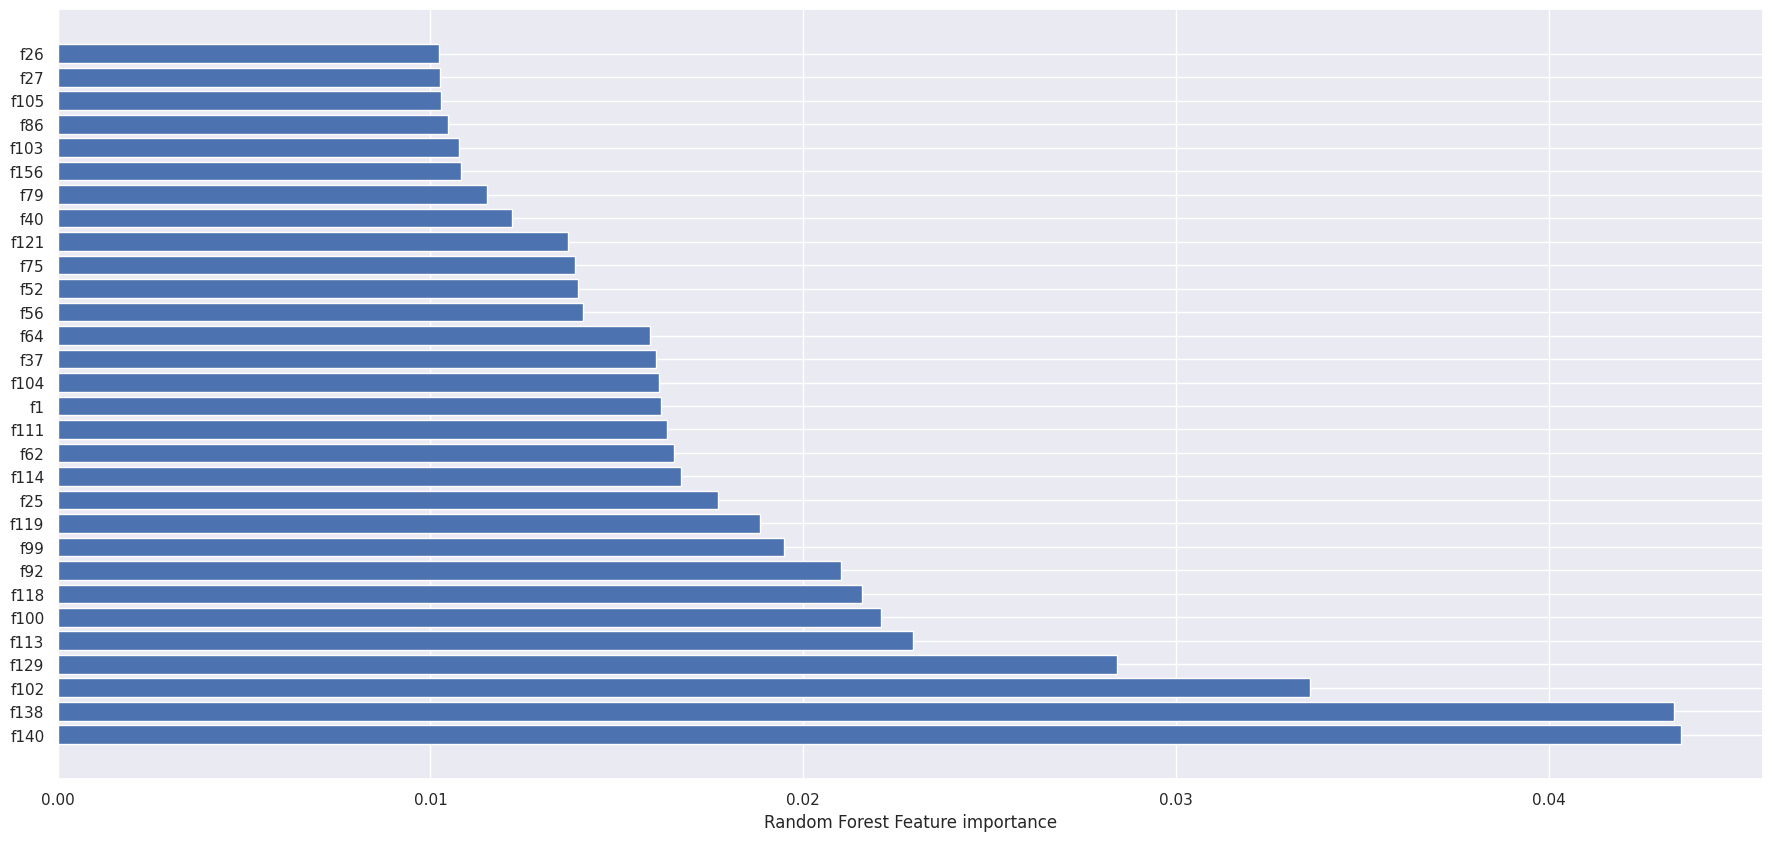

In [58]:
plt.barh(all_x.columns[sorted_idx][:cols_todisplay], importance_feat[sorted_idx][:cols_todisplay])
plt.xlabel('Random Forest Feature importance');

In [59]:
# Pick the first 11 best features
best_feats_to_train = all_x[all_x.columns[sorted_idx[:11]]]
best_feats_to_train

,f140,f138,f102,f129,f113,f100,f118,f92,f99,f119,f25
1,3777,5084,0.103,3.8889,0.47583,0.044,0.099454,0.071813,0.001,4.24,0.11571
2,3837,5035,0.107,3.8889,0.47160,0.046,0.097865,0.083737,0.001,3.66,0.12713
3,4534,5745,0.120,6.2222,0.40594,0.071,0.090324,0.092551,0.018,2.64,0.12720
4,4627,5883,0.131,6.5556,0.33671,0.066,0.113870,0.099970,0.023,3.70,0.13155
5,3956,5297,0.122,4.6667,0.45657,0.055,0.122540,0.107470,0.001,5.12,0.13801
...,...,...,...,...,...,...,...,...,...,...,...
325814,4904,5444,0.126,3.1111,0.54595,0.044,-0.528600,0.107760,0.001,8.62,0.15889
325815,3872,4691,0.094,1.5556,0.58952,0.018,-4.007400,0.100860,0.001,6.26,0.15609
325816,4275,4854,0.099,1.8889,0.59006,0.023,-0.184440,0.098917,0.001,5.86,0.16422
325817,4626,5002,0.098,2.0000,0.58910,0.021,-0.188760,0.095793,0.001,5.72,0.16766


In [66]:
X_train, X_test, y_train, y_test = train_test_split(best_feats_to_train.values, all_y, random_state = 42, stratify = all_y, test_size=0.33)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

final_model = RandomForestClassifier()
final_model.fit(X_train, y_train)

y_proba = final_model.predict_proba(X_test)
y_pred_test = final_model.predict(X_test)
y_pred_train = final_model.predict(X_train)

evaluate(y_train, y_pred_train, y_test, y_pred_test)

Accuracy: 0.99991745542593
Overall Accuracy: 0.9723569666216657
Precision: 0.9994927975076573
Overall Precision: 0.9679163262483235
Recall: 0.9997285557501316
Overall Recall: 0.955924293289029
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     12905
           2       0.99      0.99      0.99      1169
           3       1.00      1.00      1.00     24965
           4       0.99      0.99      0.99     24442
           5       0.94      0.90      0.92     15532
           6       0.95      0.97      0.96     28069
           7       0.92      0.86      0.89       323

    accuracy                           0.97    107405
   macro avg       0.97      0.96      0.96    107405
weighted avg       0.97      0.97      0.97    107405



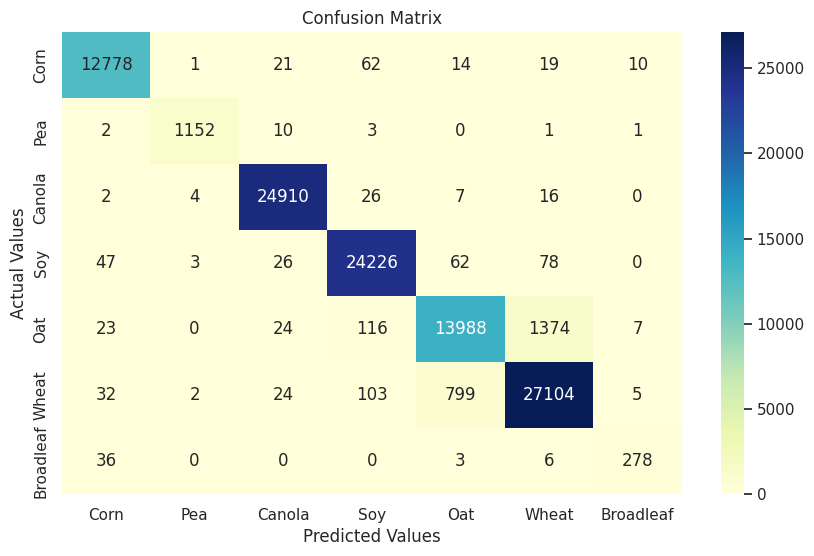

In [67]:
_ = confusion_matrix_plot(y_test, y_pred_test)